In [38]:
# Code Written By:
    # Dora Courtney
    # Lu Salamy
    # Samantha Wilder

In [39]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray  as xr
import numpy as np
import pygmt as gmt

In [40]:
# Exercise #1 - 02/14
# Create a function to open and read in daily mean temperature for NYC Central Park (2010) from a
# .txt file. Using the readlines command to make the output a list. (Exercise #1)
def read_text(file):
    with open(file, 'r') as data:
        sat = data.readlines()
    return sat

In [41]:
# Exercise #2 - 02/21

# Create a new function (lsq_fit) to calculate the model values and residual values, using the equations given
    # Function to compute y(t) and residuals (section added for Exercise #2 (02/21)) and Exercise #6
    #(04/10)).
def lsq_fit(sat_nyc_2010):
    y_0 = 55.0  # degrees Fahrenheit
    T = 365.0   # days
    
    # Construct matrix A for least-squares fitting
    A = np.zeros((len(sat_nyc_2010), 3))
    for t in range(1, 366):
        A[t-1, 0] = 1
        A[t-1, 1] = np.cos(2 * np.pi * (t - 200) / T)
        A[t-1, 2] = np.sin(2 * np.pi * (t - 200) / T)

    # Perform least-squares fit to estimate parameters
    x, _, _, _ = np.linalg.lstsq(A, sat_nyc_2010, rcond=None)

    # Compute pre-fit model values and residuals
    pre_fit_model_values = y_0 + 25 * np.cos(2 * np.pi * (np.arange(1, 366) - 200) / T)
    pre_fit_residuals = pre_fit_model_values - sat_nyc_2010

    # Compute post-fit model values and residuals
    post_fit_model_values = x[0] + x[1] * np.cos(2 * np.pi * (np.arange(1, 366) - 200) / T) + x[2] * np.sin(2 * np.pi * (np.arange(1, 366) - 200) / T)
    post_fit_residuals = post_fit_model_values - sat_nyc_2010

    # Return pre-fit and post-fit model values and residuals
    return pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals

In [42]:
# Print the observed NYC temperature to the screen (updated for Exercise #2 (02/21))
def print_data(day_of_year, sat_nyc_2010, pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals):
    print("{:<28} {:<28} {:<28} {:<28} {:<28} {:<28}".format("Day of Year (1-365)", "Observed Temperatures (\xb0F)", "Pre-fit Model (\xb0F)", "Pre-fit Residuals (\xb0F)", "Post-fit Model (\xb0F)", "Post-fit Residuals (\xb0F)"))

    for day, obs, pre_model, pre_residual, post_model, post_residual in zip(day_of_year, sat_nyc_2010, pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals):
        print("{:<28} {:<28.1f} {:<28.1f} {:<28.1f} {:<28.1f} {:<28.1f}".format(day, obs, pre_model, pre_residual, post_model, post_residual))

In [43]:
# Exercise #3 - 02/28
# We will plot the observed temperature with the day of year, as well as the residual values with the day
# of the year using a 'plot_ts' function (for Exercise #3)

# Create a function using plot_ts (time-series), so when data is fed into the function, it outputs 1 figure with 2 subplots, and saves this figure

def plot_ts(day_of_year, sat_nyc_2010, pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals):
    # First subplot ('Figure1'): 2 panel column, to plot the values passed through lsq_fit function (the pre-fit model values and residuals)
    plt.figure(figsize=(10, 8))

    # Top subplot: observations overlaid with pre-fit model values
    plt.subplot(2, 1, 1)
    plt.plot(day_of_year, sat_nyc_2010, label='Observations', color='orange', marker='.')
    plt.plot(day_of_year, pre_fit_model_values, label='Pre-fit Model', color='blue', linestyle='--', linewidth=2)
    plt.xlabel('Day of Year (1-365)')
    plt.ylabel('Temperature (°F)')
    plt.title('NYC Temperature Observations vs. Pre-fit Model Values over Day of Year')
    plt.legend()

    # Bottom subplot: pre-fit residuals
    plt.subplot(2, 1, 2)
    plt.plot(day_of_year, pre_fit_residuals, label='Pre-fit Residuals', color='green', marker='.')
    plt.axhline(0, color='gray', linestyle='--', linewidth=.75)
    plt.xlabel('Day of Year (1-365)')
    plt.ylabel('Pre-fit Residuals (°F)')
    plt.title('Pre-fit Residuals over Day of Year')
    plt.tight_layout()

    plt.savefig('Figure1.pdf')
    
    # Second subplot ('Figure3'): 2 panel column, to plot the values passed through lsq_fit function (the post-fit model values and residuals)
    plt.figure(figsize=(10, 8))

    # Top subplot: observations overlaid with pre-fit and post-fit model values
    plt.subplot(2, 1, 1)
    plt.plot(day_of_year, sat_nyc_2010, label='Observations', color='orange', marker='.')
    plt.plot(day_of_year, post_fit_model_values, label='Post-fit Model', color='red', linestyle='-.', linewidth=2)
    plt.xlabel('Day of Year (1-365)')
    plt.ylabel('Temperature (°F)')
    plt.title('NYC Temperature Observations vs. Post-fit Model Values over Day of Year')
    plt.legend()

    # Bottom subplot: post-fit residuals
    plt.subplot(2, 1, 2)
    plt.plot(day_of_year, post_fit_residuals, label='Post-fit Residuals', color='green', marker='.')
    plt.axhline(0, color='gray', linestyle='--', linewidth=.75)
    plt.xlabel('Day of Year (1-365)')
    plt.ylabel('Post-fit Residuals (°F)')
    plt.title('Post-fit Residuals over Day of Year')
    plt.tight_layout()

    plt.savefig('Figure3.pdf')
    plt.show()

In [44]:
# Exercise #4 - 03/20

# Create a function for Exercise #4 (03/20) to read the NetCDF file and extract the SAT time series for the grid point closest to NYC Central Park.
def read_netcdf(file_path, lat_nyc=40.8, lon_nyc=286.0):
    nc_file = nc.Dataset(file_path, 'r')
    lats = nc_file.variables['latitude'][:]
    lons = nc_file.variables['longitude'][:]
    lat_idx = np.argmin(np.abs(lats - lat_nyc))
    lon_idx = np.argmin(np.abs(lons - lon_nyc))
    sat_time_series = nc_file.variables['SAT'][:, lat_idx, lon_idx]
    # Compute global mean SAT (averaged over time)
    global_mean_temp = np.mean(nc_file.variables['SAT'][:])
    # Convert SAT values from Kelvin to Fahrenheit
    global_F = (global_mean_temp - 273.15) * 1.8 + 32
    nc_file.close()
    return sat_time_series, global_F

In [45]:
# Exercise #5 - 03/27
# Using the time series of ERA5 surface air temperature (SAT) for the grid point closest to NYC (03/20 coding exercise), produce a histogram plot showing the
# probability density function of the annual-mean SAT.
    # The SAT should be converted to units of °F to be consistent with the units of temperature given in the other data file that we’ve worked with

# First define the function for plot_hist using the sat_time _series from (03/20)

def plot_hist(sat_time_series):
    sat_F = (sat_time_series - 273.15) * 1.8 + 32
    annual_mean_sat = np.mean(sat_F.reshape(-1, 12), axis=1)
    plt.figure(figsize=(10, 8))
    plt.hist(annual_mean_sat, edgecolor='black', bins=np.arange(min(annual_mean_sat), max(annual_mean_sat) + 0.5, 0.5), density=True)
    plt.xlabel('Annual-Mean Surface Air Temperature (°F)')
    plt.ylabel('Probability Density')
    plt.title('Probability Density Function of Annual-Mean SAT')
    plt.tight_layout()
    plt.savefig('Figure2.pdf')
    plt.show()

In [ ]:
# Exercise #7 - 04/17
def plot_map(global_F):
    t-grid = xr.DataArray(global_F)
    fig = gmt.Figure()

    # Make some changes in the GMT parameters for esthetic purpose
    gmt.config(FONT_ANNOT = '9p', FONT_LABEL = '10p', FONT_TITLE = '14p', MAP_TITLE_OFFSET = '0p', MAP_TICK_LENGTH = '0p')

    # Make a map using the Mollweide map projection
    fig.grdimage(grid = t_grid, region = 'd', projection = 'W180/12c', frame = ['f', '+t"Geographic plot example"'], dpi = 600)

    # Plot the coastlines
    fig.coast(shorelines = '1/0.5p,black', resolution = 'c')

    # Add a color bar
    fig.colorbar(frame = ['x+l"Surface Air Temperature (@.F)"'])

    ### Save figure 
    fig.show()
    fig.savefig('Figure4.pdf')

Day of Year (1-365)          Observed Temperatures (°F)   Pre-fit Model (°F)           Pre-fit Residuals (°F)       Post-fit Model (°F)          Post-fit Residuals (°F)     
1                            37.0                         31.0                         -6.0                         34.1                         -2.9                        
2                            26.0                         30.9                         4.9                          34.0                         8.0                         
3                            20.0                         30.8                         10.8                         33.9                         13.9                        
4                            25.0                         30.7                         5.7                          33.8                         8.8                         
5                            25.0                         30.6                         5.6                          33.8          

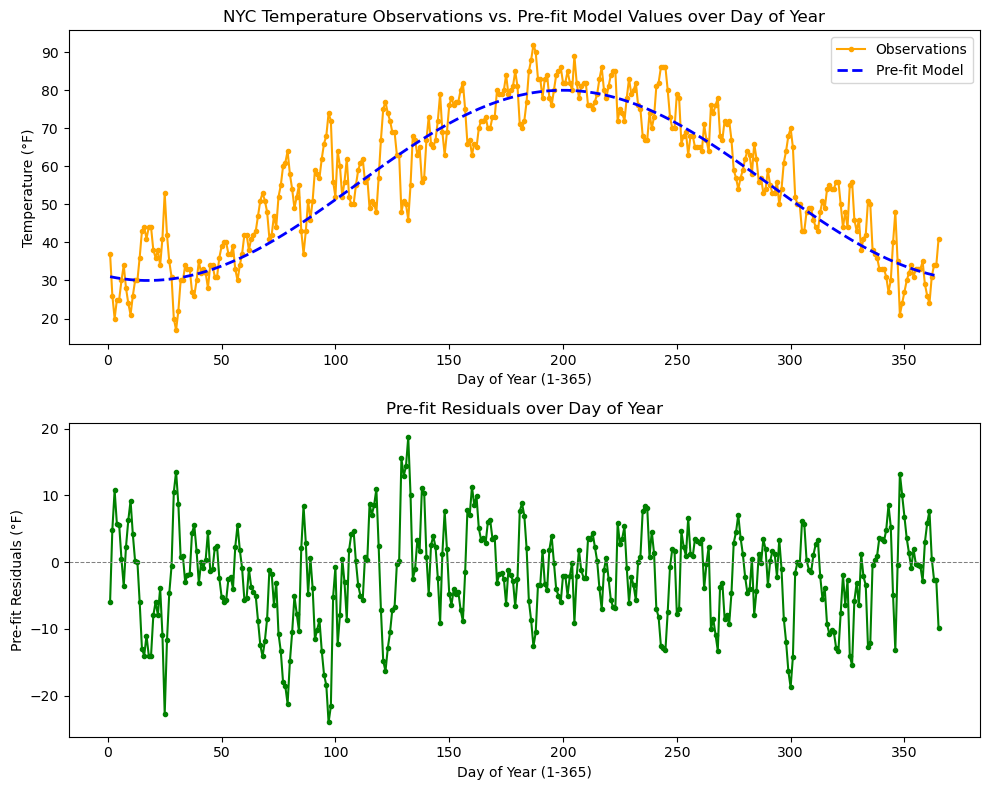

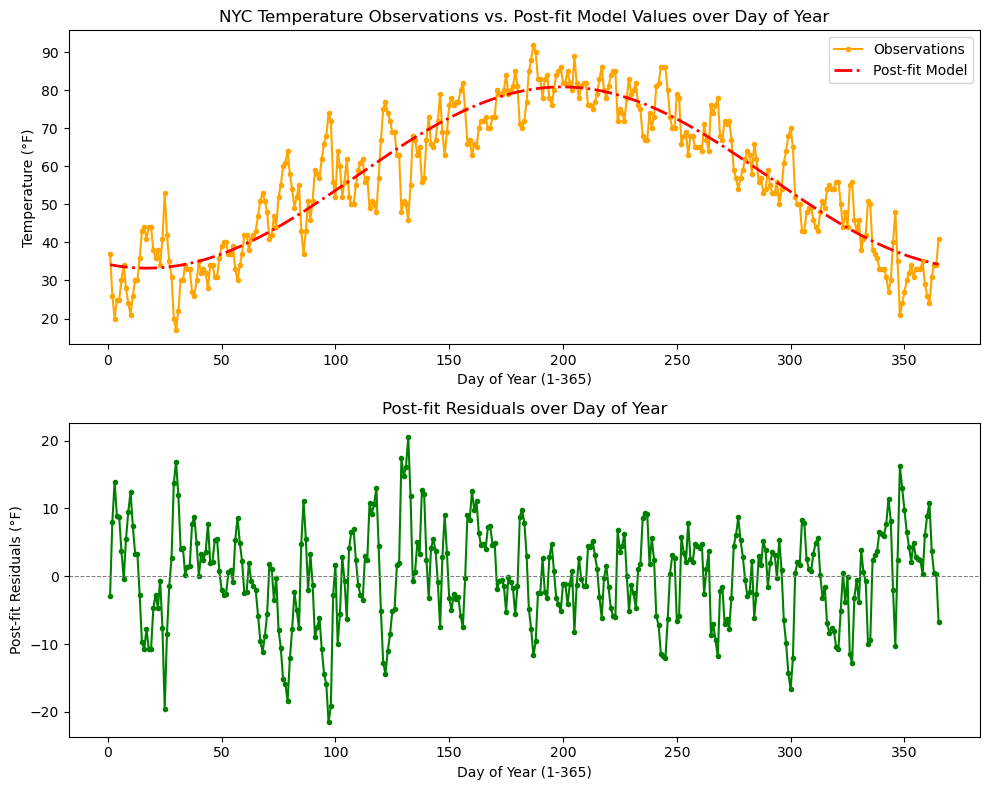

SAT Time Series for NYC Central Park Closest Grid Point: 
[271.34905926 271.63646053 276.02329711 283.64736517 290.61728678
 293.76106878 296.7091358  296.85724443 293.35553325 287.1085228
 279.72953926 275.1558037  272.14249835 273.91627552 271.70346206
 283.86776492 288.49968601 293.7469632  295.30386701 295.25978706
 291.35254034 285.44759031 280.6552182  269.71810113 267.34659985
 272.40345165 276.12908898 280.63758622 286.93043981 293.76812157
 296.36707539 295.39379011 294.63385178 286.48258752 280.29376261
 273.05054531 271.03168363 270.32464124 276.04974508 283.02319309
 289.12385809 294.49632234 294.91772666 294.41697843 289.97724592
 285.35237762 277.80589026 270.7072552  269.58762448 268.42391381
 276.76207706 282.98263953 288.26870707 294.0096797  296.47992007
 294.41345203 289.33896825 287.16494514 281.89121998 270.18887499
 271.99791612 270.9682085  277.11119026 281.57913394 290.13593373
 293.28500533 296.40762895 294.02202208 291.66286319 284.45138345
 281.17007201 274.0

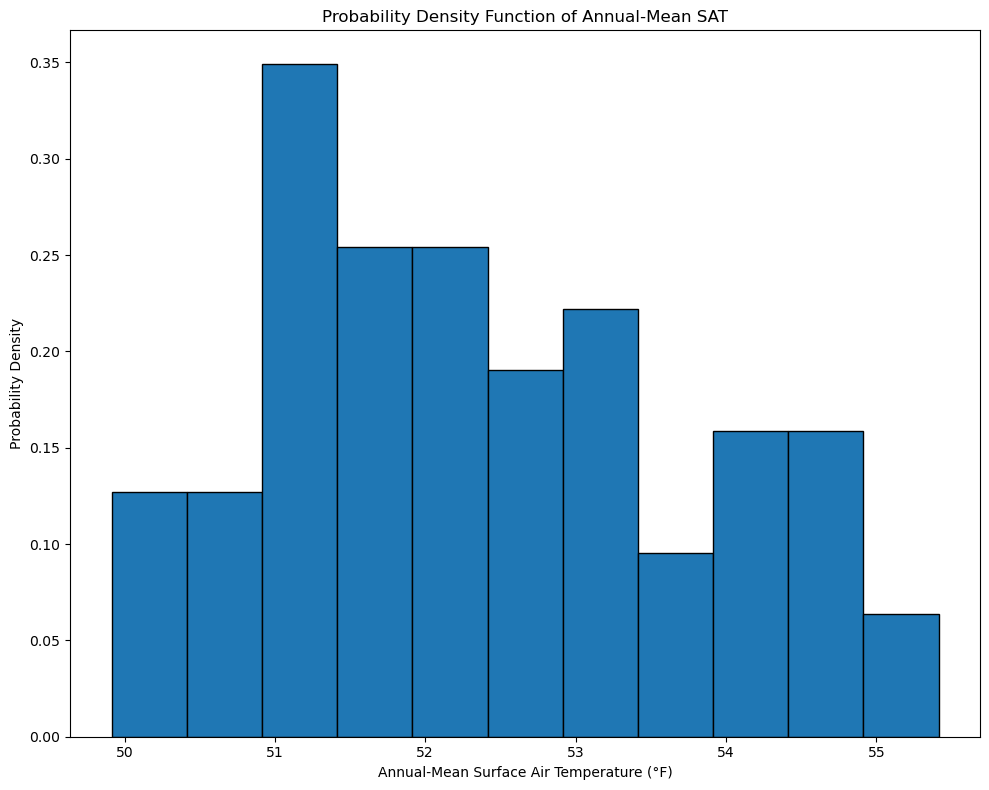

40.926084682289606


In [46]:
# Main Routine (updated for Exercise #6 (04/10))

# Specify the file name:
file_text = 'nyc_temp_2010.txt'
    # this text file contains the daily mean temperatures for NYC Central Park (2010)

# Now call the functions (read and print):
sat_nyc_2010 = read_text(file_text)
    # this function is passed the file name, reads in the temperature data, and returns the data

# Convert to integers
sat_nyc_2010 = [int(i) for i in sat_nyc_2010]


# Generate day_of_year list (1 to 365)
day_of_year = list(range(1, 366))

# Obtain pre-fit model values and residuals
pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals = lsq_fit(sat_nyc_2010)

# Print the data, now including pre-fit model values (3) and residuals (4) in addition to days of year (1) and observed
# temperatures (2) from Exercise #1 (02/14).
print_data(day_of_year, sat_nyc_2010, pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals)
    # this null function is passed the temperature data. The function prints to the screen four columns with headers:
        # - one column indicating the day of the year (1-365),
        # - and a second column indicating the temperature observation for each day.
    # Be sure to indicate the units of the temperature data (°F)

# Call the plotting (time-series) function and display/save the figure (for Exercise #3)
plot_ts(day_of_year, sat_nyc_2010, pre_fit_model_values, pre_fit_residuals, post_fit_model_values, post_fit_residuals)

# Using/calling the read_netCDF function, extract the SAT time series for the grid point closest to NYC Central Park (Exercise #4)
file_path = 'ERA5_SAT_195901-202112.nc'
sat_time_series,global_F = read_netcdf(file_path)

print('SAT Time Series for NYC Central Park Closest Grid Point: ')
print(sat_time_series)

# Call the plotting histogram function and display/save the figure (for Exercise #5 - 03/27)
plot_hist(sat_time_series)